# DATA GATHERING
---

In [2]:
import warnings
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import pydotplus
import graphviz
from six import StringIO
from sklearn import preprocessing
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    KFold,
    ShuffleSplit,
    cross_val_score,
    cross_val_predict
)
from sklearn import model_selection
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score
)
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    VotingClassifier
)
import smote_variants as sv

# Konfigurasi
seed = 42
pd.options.display.max_columns = None 
sns.set_palette("Set1")
sns.set_style("whitegrid")

In [3]:
data = pd.read_csv("C:/Users/ACER/OneDrive/Kuliah/SEM 8/Komputasi Statistika II/Project UAS/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
print('Dataset ini memiliki', data.shape[0], 'baris (customers) dan', data.shape[1], 'variabel')

Dataset ini memiliki 7043 baris (customers) dan 21 variabel


The data set includes information about:
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

## 1.1 Data Type

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Total Charges harusnya bertipe numerik, tetapi setelah dicek bertipe object, kemungkinan karena ada blank values.

In [6]:
print('Nilai unik tiap variabel: \n')
data.nunique()

Nilai unik tiap variabel: 



customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

## 1.2 Missing Value

In [7]:
data.replace(r'^\s*$', np.nan, regex=True, inplace = True) # mengganti cell yang blank menjadi nan

In [8]:
# Menampilkan persentase missing values (NaN) untuk setiap kolom di data
df_null = data.isnull().mean(axis = 0) # Menghitung rata-rata nilai NaN per kolom
df_null = df_null[df_null > 0] * 100 # Filter hanya kolom yang memiliki nilai NaN, dan konversi ke persen
print("Missing values columns: \n\n{}\n".format(df_null.sort_values(axis=0, ascending=False)))

Missing values columns: 

TotalCharges    0.156183
dtype: float64



In [9]:
# Missing value untuk pelanggan yang berhenti berlangganan 
df_null = data[data['Churn'] == 'Yes'].isnull().sum() 
df_null = df_null[df_null > 0] # Menyaring hanya kolom yang punya missing value (> 0)
print("Missing values columns: \n\n{}\n".format(df_null.sort_values(axis=0, ascending=False)))

Missing values columns: 

Series([], dtype: int64)



In [10]:
# Missing value untuk pelanggan yang tidak berhenti berlangganan 
df_null = data[data['Churn'] == 'No'].isnull().sum()
df_null = df_null[df_null > 0] # Menyaring hanya kolom yang punya missing value (> 0)
print("Missing values columns: \n\n{}\n".format(df_null.sort_values(axis=0, ascending=False)))

Missing values columns: 

TotalCharges    11
dtype: int64



In [11]:
# Filter baris yang churn-nya 'No' dan memiliki setidaknya satu nilai NaN
missing_rows = data[(data['Churn'] == 'No') & (data.isnull().any(axis=1))]
missing_rows

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Hanya variabel Total Charges yang memiliki missing value sebanyak 11 customer dan semuanya tidak berhenti berlangganan (Churn = No). Terlihat juga 11 customer tersebut baru memiliki tenure 0 bulan. Hal ini cukup masuk akal karena pelanggan yang belum dikenakan tagihan akan memiliki Total Charges sebesar nol. Oleh karena itu, missung value akan diganti dengan nol.

## Data Inconsistency

Beberapa services memerlukan pembelian produk tertentu. Oleh karena itu, untuk memverifikasi keberadaan data yang tidak konsisten, services akan dianalisis satu per satu, khususnya dalam kasus di mana customer tidak memiliki produk yang diperlukan. Diharapkan bahwa jika customer tidak memiliki produk tersebut, maka mereka juga tidak menggunakan servicenya.

In [12]:
data[data['PhoneService'] == 'No'].MultipleLines.value_counts()

MultipleLines
No phone service    682
Name: count, dtype: int64

Jika pelanggan tidak memiliki layanan telepon (PhoneService == 'No'), maka logisnya dia juga tidak bisa punya multiple lines (karena itu adalah layanan tambahan dari telepon).

In [13]:
data[data['InternetService'] == 'No'].OnlineSecurity.value_counts()

OnlineSecurity
No internet service    1526
Name: count, dtype: int64

In [14]:
data[data['InternetService'] == 'No'].OnlineBackup.value_counts()

OnlineBackup
No internet service    1526
Name: count, dtype: int64

In [15]:
data[data['InternetService'] == 'No'].DeviceProtection.value_counts()

DeviceProtection
No internet service    1526
Name: count, dtype: int64

In [16]:
data[data['InternetService'] == 'No'].TechSupport.value_counts()

TechSupport
No internet service    1526
Name: count, dtype: int64

In [17]:
data[data['InternetService'] == 'No'].StreamingTV.value_counts()

StreamingTV
No internet service    1526
Name: count, dtype: int64

In [18]:
data[data['InternetService'] == 'No'].StreamingMovies.value_counts()

StreamingMovies
No internet service    1526
Name: count, dtype: int64

Tidak ada atribut yang inkonsisten.

# EXPLORATORY DATA
---

Pada bagian ini, statistik deskriptif dari variabel-variabel akan dievaluasi, serta akan dilakukan analisis univariat dan bivariat.

In [19]:
# Set customerID sebagai index
data.set_index('customerID', inplace = True)

In [20]:
# Mengubah nilai di kolom SeniorCitizen dari bentuk angka (0 atau 1) menjadi bentuk teks (string), yaitu 'No' dan 'Yes'.
data['SeniorCitizen'] = data.SeniorCitizen.map({0: 'No', 1: 'Yes'}) 

In [21]:
# Mengubah tipe data Total Charges menjadi numerik
data = data.astype({'TotalCharges': 'float64'})

## 2.1 Descriptive statistics

### 2.1.1 Variabel Numerik

In [22]:
print('Statistika deskriptif dari variabel numerik: ')
data.describe().T

Statistika deskriptif dari variabel numerik: 


,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


Dari output di atas, bisa disimpulkan:
- Customer yang memiliki masa tenure terlama adalah 6 tahun (72 bulan)
- Customer yang memiliki masa tenure tercepat adalah 0 bulan, artinya mereka adalah pelanggan baru. 
- Monthly charges dan total charges tampak rasional. Total charges = 0 akan diperbaiki pada langkah selanjutnya.

### 2.1.2 Variabel Kategorik

In [23]:
print('Statistika deskriptif dari variabel kategorik: ')
data.describe(include='object').T

Statistika deskriptif dari variabel kategorik: 


,count,unique,top,freq
gender,7043,2,Male,3555
SeniorCitizen,7043,2,No,5901
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


Rata-rata customer adalah pria muda yang tidak memiliki pasangan (Partner) dan tanggungan (Dependents), hanya menggunakan satu saluran telepon (Multiple Lines = No), menggunakan internet fiber optik (Internet Service = Fiber Optic), dan tidak menggunakan layanan internet lainnya. Selain itu, ia memiliki kontrak bulanan (Month-to-month contract) dan menggunakan tagihan tanpa kertas (Paperless Billing) dengan pembayaran melalui cek elektronik (Electronic check	Payment Method).

### 2.1.3 Variabel Dependen

C:\Users\ACER\AppData\Local\Temp\ipykernel_15784\3052932202.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, y="Churn", palette='Set1')


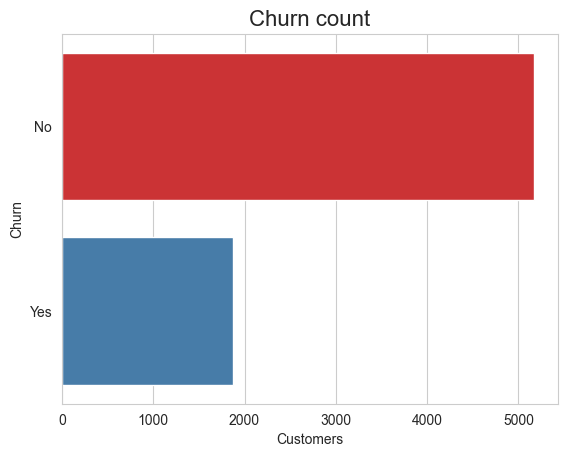

In [24]:
sns.countplot(data=data, y="Churn", palette='Set1')
plt.title('Churn count', fontsize=16)
plt.xlabel('Customers')
plt.ylabel('Churn')
plt.show()

In [25]:
# Menampilan persentase distribusi relatif dari variabel dependen
print('Distribusi relatif (persentase) dari variabel dependen: ')
data.Churn.value_counts()/data.shape[0] * 100

Distribusi relatif (persentase) dari variabel dependen: 


Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64

Hanya 26% customer yang churn, sisanya, 73% tidak churn. Ada ketidakseimbangan ekstrim antara keduanya.

## 2.2 Univariate analysis

Melihat visualisasi data untuk mempermudah proses modeling dan mendapatkan beberapa insight.

### 2.2.1 Service information

C:\Users\ACER\AppData\Local\Temp\ipykernel_15784\2723132782.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="PhoneService", ax=axs[0,0], palette=palette)
C:\Users\ACER\AppData\Local\Temp\ipykernel_15784\2723132782.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="MultipleLines", ax=axs[0,1], palette=palette)
C:\Users\ACER\AppData\Local\Temp\ipykernel_15784\2723132782.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="InternetService", ax=axs[0,2], palette=palette)
C:\Users\ACER\AppData\Lo

C:\Users\ACER\AppData\Local\Temp\ipykernel_15784\2723132782.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="DeviceProtection", ax=axs[1,2], palette=palette)
C:\Users\ACER\AppData\Local\Temp\ipykernel_15784\2723132782.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="TechSupport", ax=axs[2,0], palette=palette)
C:\Users\ACER\AppData\Local\Temp\ipykernel_15784\2723132782.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="StreamingTV", ax=axs[2,1], palette=palette)
C:\Users\ACER\AppData\Loc

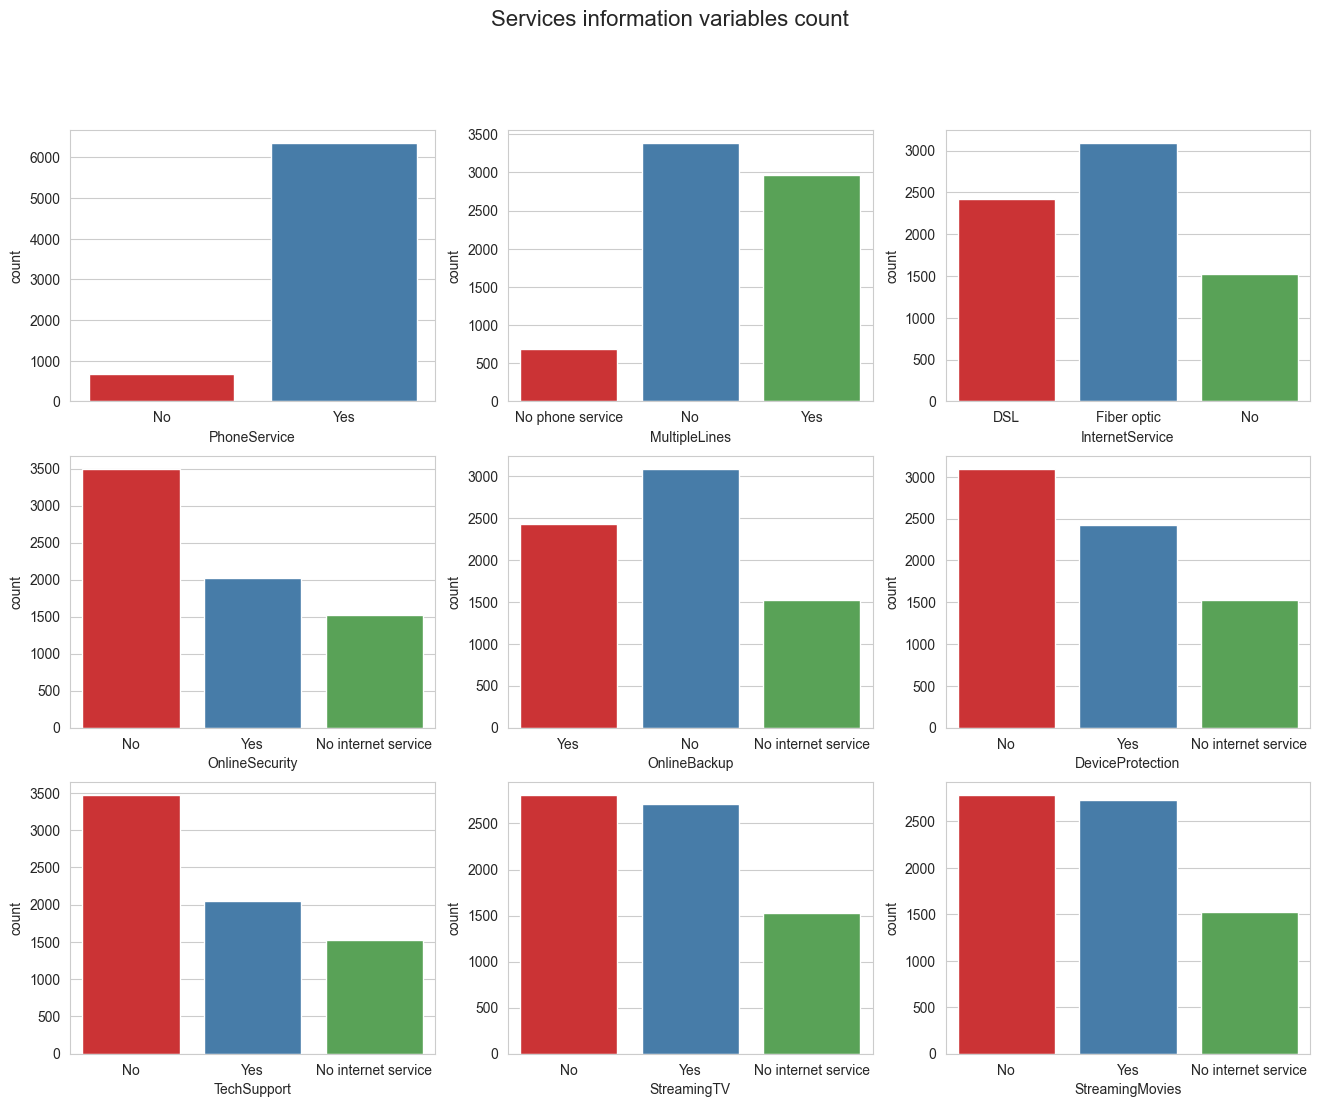

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
palette = 'Set1'
sns.countplot(data=data, x="PhoneService", ax=axs[0,0], palette=palette)
sns.countplot(data=data, x="MultipleLines", ax=axs[0,1], palette=palette)
sns.countplot(data=data, x="InternetService", ax=axs[0,2], palette=palette)
sns.countplot(data=data, x="OnlineSecurity", ax=axs[1,0], palette=palette)
sns.countplot(data=data, x="OnlineBackup", ax=axs[1,1], palette=palette)
sns.countplot(data=data, x="DeviceProtection", ax=axs[1,2], palette=palette)
sns.countplot(data=data, x="TechSupport", ax=axs[2,0], palette=palette)
sns.countplot(data=data, x="StreamingTV", ax=axs[2,1], palette=palette)
sns.countplot(data=data, x="StreamingMovies", ax=axs[2,2], palette=palette)
fig.suptitle('Services information variables count', fontsize=16)
plt.show()

Pada bagian Service Information, semua variabel berupa kategorik. Kebanyakan memiliki 3 kelas. Contohnya pada Streaming TV ada kelas No, Yes, dan No Internet Service.

### 2.2.2 Customer infromation

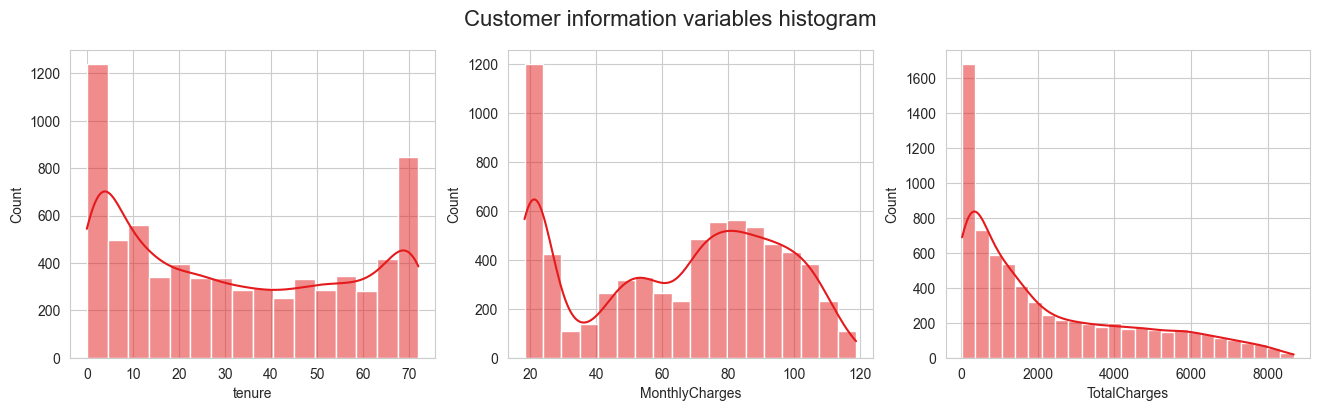

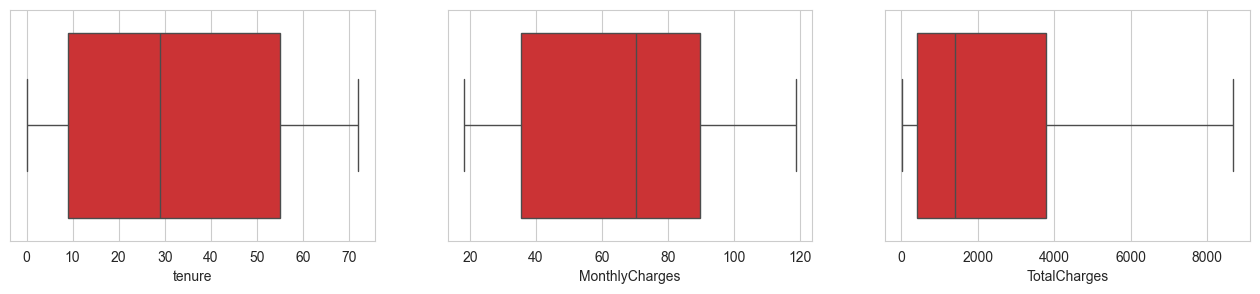

C:\Users\ACER\AppData\Local\Temp\ipykernel_15784\2780414265.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="Contract", ax=axs[0], palette=palette)
C:\Users\ACER\AppData\Local\Temp\ipykernel_15784\2780414265.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="PaperlessBilling", ax=axs[1], palette=palette)
C:\Users\ACER\AppData\Local\Temp\ipykernel_15784\2780414265.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, y="PaymentMethod", palette=palette)


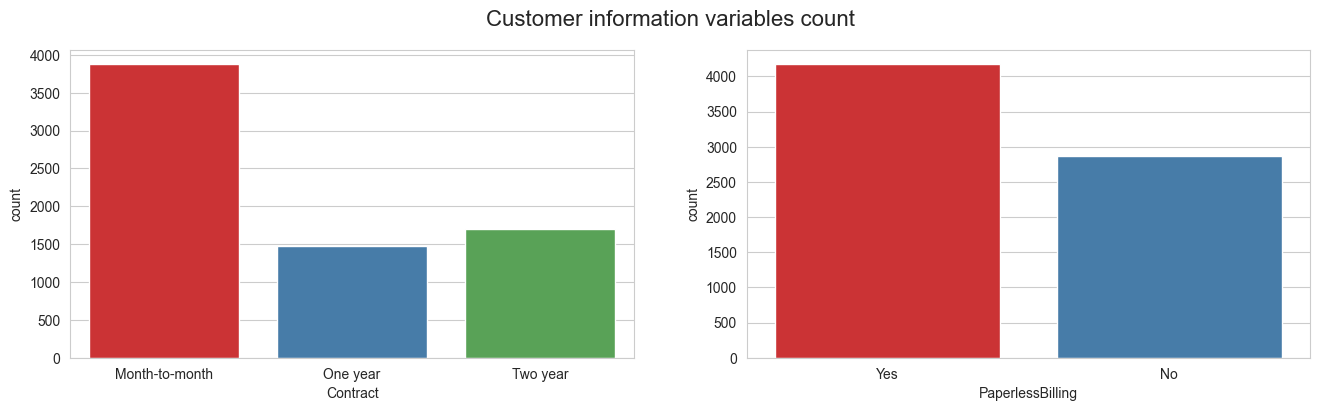

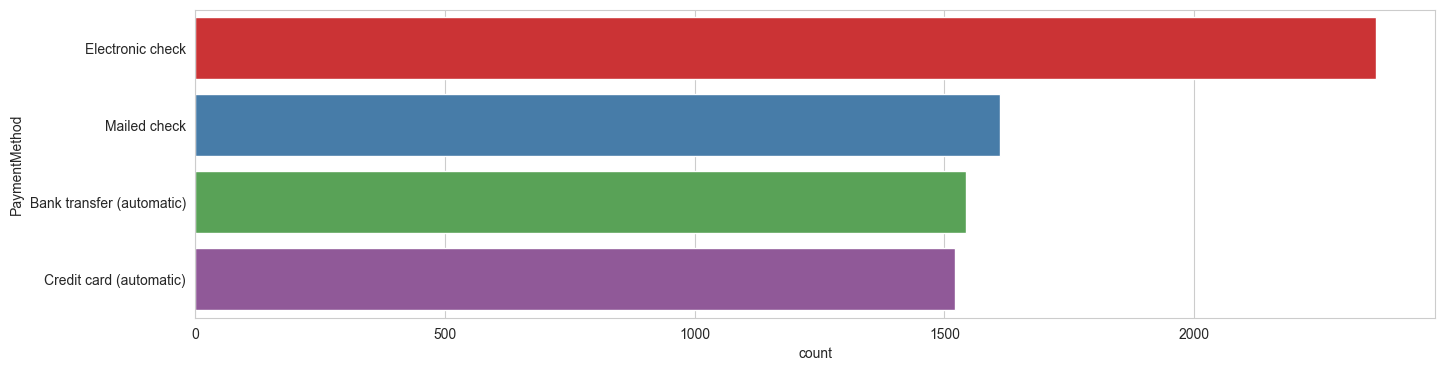

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
sns.histplot(data=data, x="tenure", kde=True, ax=axs[0])
sns.histplot(data=data, x="MonthlyCharges", kde=True, ax=axs[1])
sns.histplot(data=data, x="TotalCharges", kde=True, ax=axs[2])
fig.suptitle('Customer information variables histogram', fontsize=16)
fig, axs = plt.subplots(1, 3, figsize=(16, 3))
sns.boxplot(data=data, ax=axs[0], x='tenure')
sns.boxplot(data=data, ax=axs[1], x='MonthlyCharges')
sns.boxplot(data=data, ax=axs[2], x='TotalCharges')
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=data, x="Contract", ax=axs[0], palette=palette)
sns.countplot(data=data, x="PaperlessBilling", ax=axs[1], palette=palette)
fig.suptitle('Customer information variables count', fontsize=16)
fig, axs = plt.subplots(1, 1, figsize=(16, 4))
sns.countplot(data=data, y="PaymentMethod", palette=palette)
plt.show()

- Masa tenure customer memiliki distribusi yang hampir seragam, dengan puncak pertama di < 5 bulan dan puncak kedua di > 60 bulan.
- Monthly Charges memiliki 3 puncak: 20 dolar, 50 dolar, dan 90 dolar.
- Total Charges memiliki distribusi one-tailed.
- Menggunakan metode IQR, tidak ada variabel numerik yang outlier.
- Mayoritas customer memiliki kontrak month-to-month, two year, lalu one year.
- Mayoritas customer memiliki paperless billing.
- Mayoritas customer menggunakan metode pembayaran electronic check, disusul mailed check, bank transfer, dan credit card.

### 2.2.3 Sociodemographic information

C:\Users\ACER\AppData\Local\Temp\ipykernel_15784\3594740193.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="gender", ax=axs[0,0], palette=palette)
C:\Users\ACER\AppData\Local\Temp\ipykernel_15784\3594740193.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="SeniorCitizen", ax=axs[0,1], palette=palette)
C:\Users\ACER\AppData\Local\Temp\ipykernel_15784\3594740193.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="Partner", ax=axs[1,0], palette=palette)
C:\Users\ACER\AppData\Local\Temp\ipyke

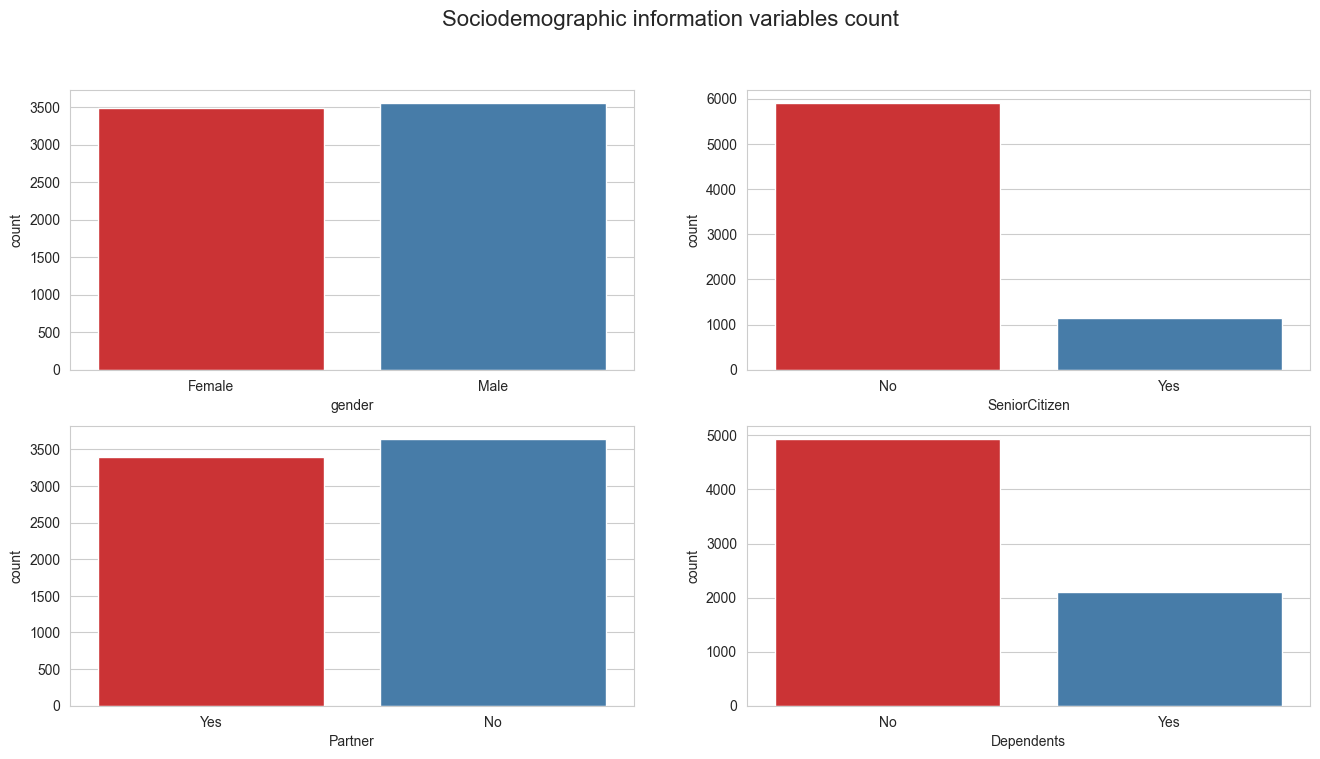

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
sns.countplot(data=data, x="gender", ax=axs[0,0], palette=palette)
sns.countplot(data=data, x="SeniorCitizen", ax=axs[0,1], palette=palette)
sns.countplot(data=data, x="Partner", ax=axs[1,0], palette=palette)
sns.countplot(data=data, x="Dependents", ax=axs[1,1], palette=palette)
fig.suptitle('Sociodemographic information variables count', fontsize=16)
plt.show()

* Dataset ini menunjukkan variabel jenis kelamin (Gender) yang terdistribusi dengan baik
* Hal yang sama juga terjadi pada variabel pasangan (Partner)
* Sebagian besar konsumen bukan warga lanjut usia (Senior Citizen = No) dan tidak memiliki tanggungan (Dependents = No)

## 2.3 Bivariate analysis

### 2.3.1 Services information

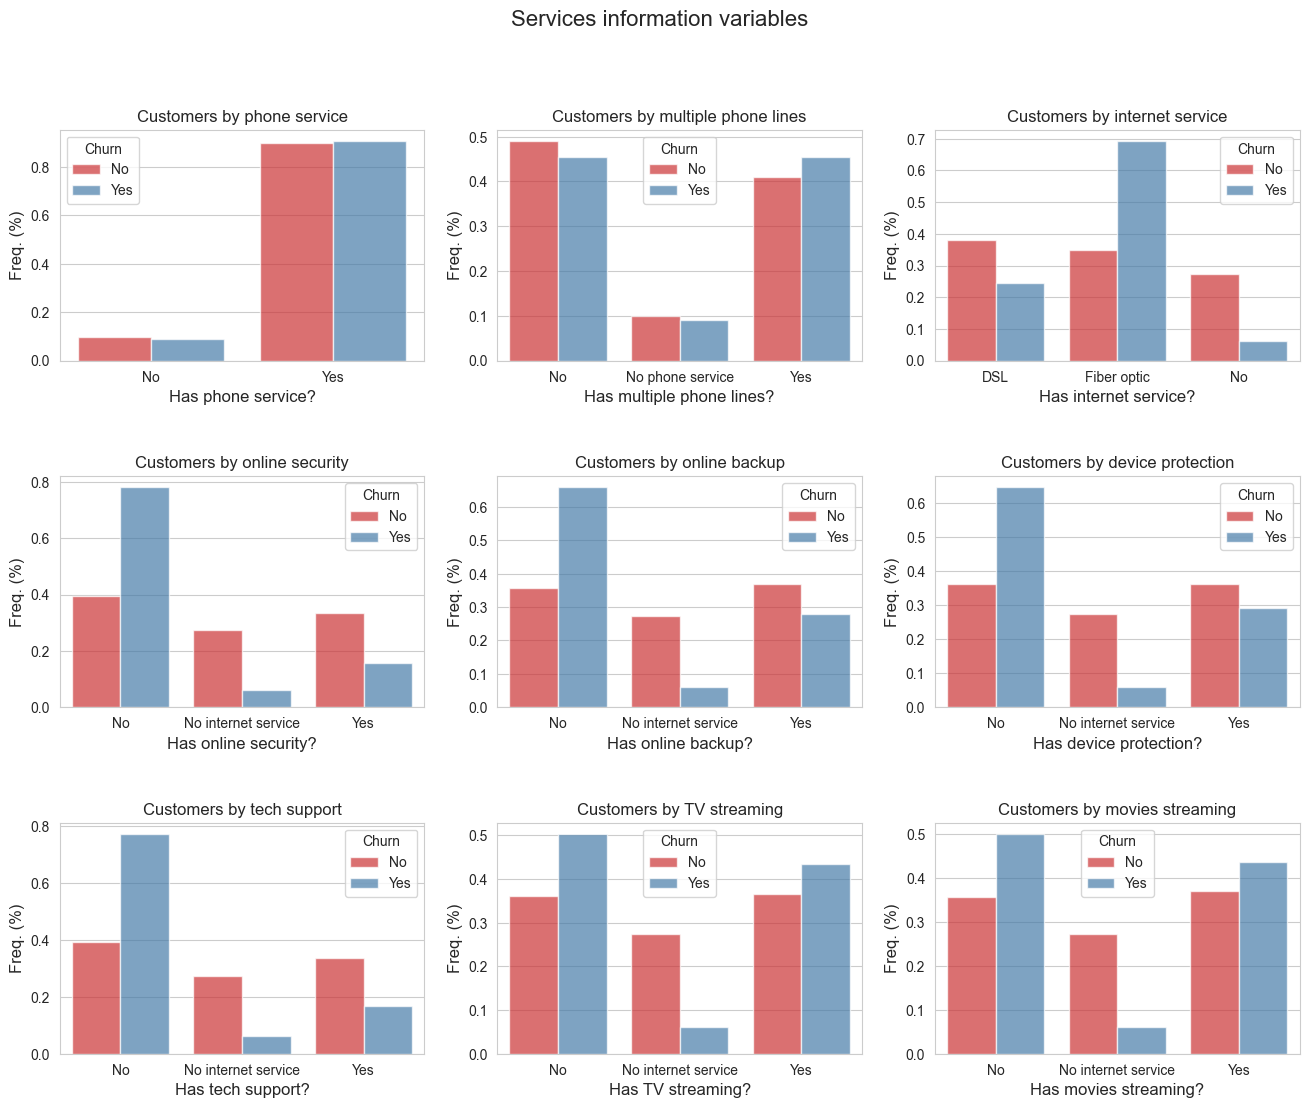

In [29]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))

freq = (data.groupby(['PhoneService','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='PhoneService', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[0,0])
ax1.title.set_text('Customers by phone service')
ax1.set_xlabel('Has phone service?', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

freq = (data.groupby(['MultipleLines','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='MultipleLines', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[0,1])
ax1.title.set_text('Customers by multiple phone lines')
ax1.set_xlabel('Has multiple phone lines?', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

freq = (data.groupby(['InternetService','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='InternetService', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[0,2])
ax1.title.set_text('Customers by internet service')
ax1.set_xlabel('Has internet service?', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

freq = (data.groupby(['OnlineSecurity','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='OnlineSecurity', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[1,0])
ax1.title.set_text('Customers by online security')
ax1.set_xlabel('Has online security?', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

freq = (data.groupby(['OnlineBackup','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='OnlineBackup', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[1,1])
ax1.title.set_text('Customers by online backup')
ax1.set_xlabel('Has online backup?', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

freq = (data.groupby(['DeviceProtection','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='DeviceProtection', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[1,2])
ax1.title.set_text('Customers by device protection')
ax1.set_xlabel('Has device protection?', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

freq = (data.groupby(['TechSupport','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='TechSupport', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[2,0])
ax1.title.set_text('Customers by tech support')
ax1.set_xlabel('Has tech support?', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

freq = (data.groupby(['StreamingTV','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='StreamingTV', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[2,1])
ax1.title.set_text('Customers by TV streaming')
ax1.set_xlabel('Has TV streaming?', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

freq = (data.groupby(['StreamingMovies','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='StreamingMovies', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[2,2])
ax1.title.set_text('Customers by movies streaming')
ax1.set_xlabel('Has movies streaming?', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

fig.suptitle('Services information variables', fontsize=16)
fig.subplots_adjust(hspace=.5)
plt.show()

 - Customer dengan phone service memiliki kecenderungan sedikit lebih besar untuk berhenti berlangganan dibandingkan yang lain.
 - Customer dengan multiple phone lines memiliki kecenderungan sedikit lebih besar untuk berhenti berlangganan dibandingkan yang lain.
 - Customer dengan fiber optic internet service smemiliki kecenderungan sedikit lebih besar untuk berhenti berlangganan dibandingkan customer DSL. Selain itu, customers dengan internet services memiliki kecenderungan sedikit lebih besar untuk berhenti berlangganan dibandingkan yang lain.
 - Customers yang tidak memiliki online security, online backup, device protection, dan tech support services memiliki kecenderungan sedikit lebih besar untuk berhenti berlangganan dibandingkan yang lain.
 - Customers yang tidak memiliki TV streaming dan movies streaming memiliki kecenderungan sedikit lebih besar untuk berhenti berlangganan dibandingkan yang lain.

### 2.3.2 Customer information

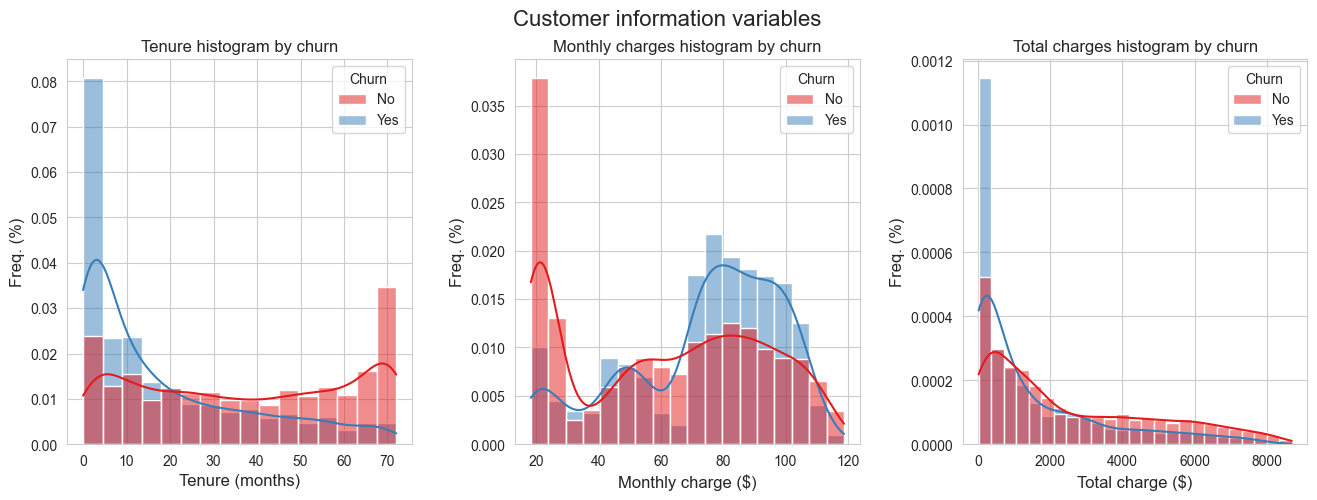

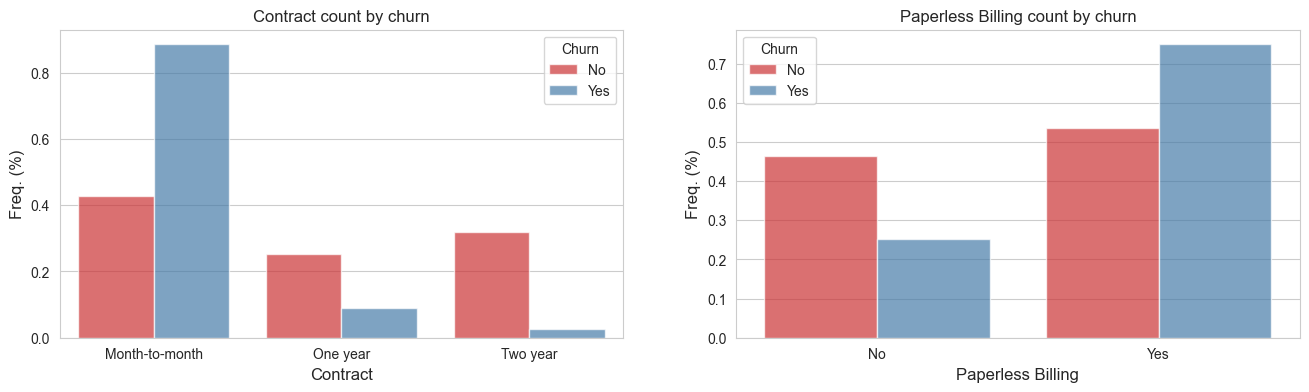

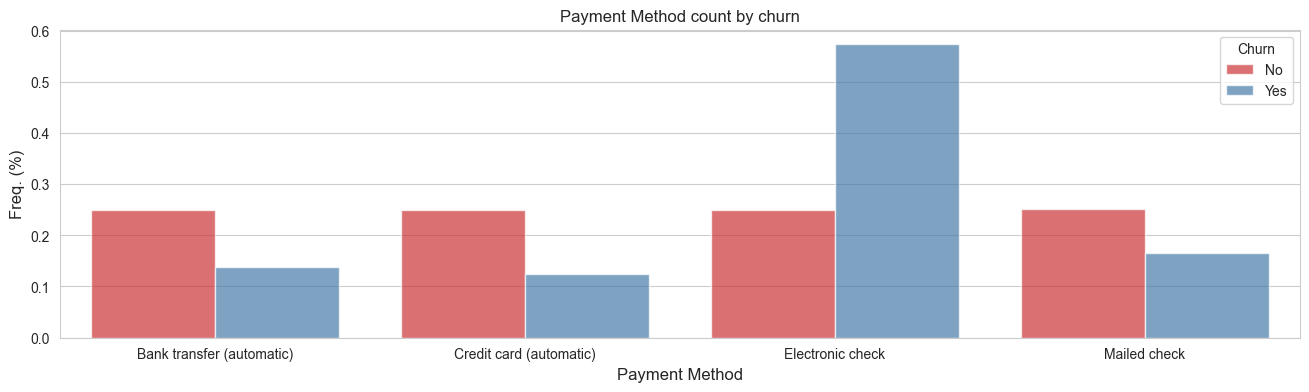

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
ax1 = sns.histplot(data=data, x="tenure", kde=True, ax=axs[0], hue=data.Churn, stat="density", common_norm = False)
ax1.title.set_text('Tenure histogram by churn')
ax1.set_xlabel('Tenure (months)', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

ax1 = sns.histplot(data=data, x="MonthlyCharges", kde=True, ax=axs[1], hue=data.Churn, stat="density", common_norm = False)
ax1.title.set_text('Monthly charges histogram by churn')
ax1.set_xlabel('Monthly charge ($)', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

ax1 = sns.histplot(data=data, x="TotalCharges", kde=True, ax=axs[2], hue=data.Churn, stat="density", common_norm = False)
ax1.title.set_text('Total charges histogram by churn')
ax1.set_xlabel('Total charge ($)', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

fig.suptitle('Customer information variables', fontsize=16)
fig.subplots_adjust(hspace=.8, wspace=.3)

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
freq = (data.groupby(['Contract','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='Contract', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[0])
ax1.title.set_text('Contract count by churn')
ax1.set_xlabel('Contract', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

freq = (data.groupby(['PaperlessBilling','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='PaperlessBilling', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[1])
ax1.title.set_text('Paperless Billing count by churn')
ax1.set_xlabel('Paperless Billing', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

fig.subplots_adjust(hspace=.5)

fig, axs = plt.subplots(1, 1, figsize=(16, 4))
freq = (data.groupby(['PaymentMethod','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='PaymentMethod', hue='Churn', y='Frequência', data=freq, alpha=0.7)
ax1.title.set_text('Payment Method count by churn')
ax1.set_xlabel('Payment Method', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)


fig.subplots_adjust(hspace=.5)
plt.show()

- Customer dengan masa tenure yang lebih singkat memiliki kecenderungan lebih besar untuk berhenti berlangganan (Churn = yes) dibandingkan yang lain.
- Customer dengan tagihan bulanan (Monthly Charges) yang lebih rendah memiliki kecenderungan untuk terus berlangganan (Churn = no) dibandingkan yang lain.
- Customer dengan sistem pembayaran bulanan (month-to-month) memiliki kecenderungan lebih besar untuk berhenti berlangganan (Churn = yes) dibadningkan yang lain.
- Customer yang membayar menggunakan tagihan tanpa kertas (Paperless Billing) memiliki kecenderungan lebih besar untuk berhenti berlangganan (Churn = yes) dibandingkan yang lain.
- Customer dengan metode pembayaran menggunakan cek elektronik (Payment Method = Eletronic Check) tampaknya memiliki kecenderungan lebih besar untuk berhenti berlangganan (Churn = yes) dibandingkan yang lain.
- Customer dengan metode pembayaran otomatis (Payment Method = Bank Transfer, Credit Card) tampaknya memiliki kecenderungan untuk terus berlangganan (Churn = No) dibandingkan yang lain.

### 2.3.3 Sociodemographic information

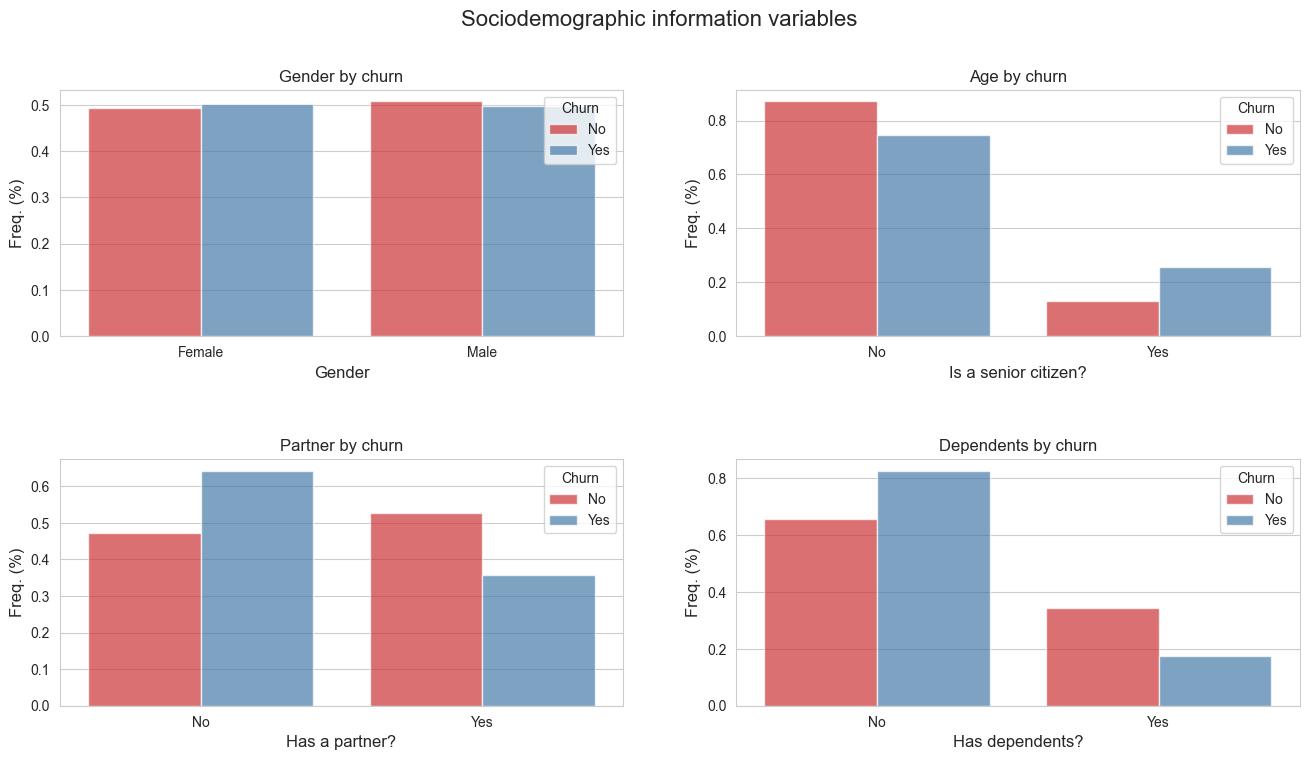

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
freq = (data.groupby(['gender','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='gender', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[0,0])
ax1.title.set_text('Gender by churn')
ax1.set_xlabel('Gender', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

freq = (data.groupby(['SeniorCitizen','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='SeniorCitizen', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[0,1])
ax1.title.set_text('Age by churn')
ax1.set_xlabel('Is a senior citizen?', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

freq = (data.groupby(['Partner','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='Partner', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[1,0])
ax1.title.set_text('Partner by churn')
ax1.set_xlabel('Has a partner?', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

freq = (data.groupby(['Dependents','Churn']).size() / data.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax1 = sns.barplot(x='Dependents', hue='Churn', y='Frequência', data=freq, alpha=0.7, ax=axs[1,1])
ax1.title.set_text('Dependents by churn')
ax1.set_xlabel('Has dependents?', fontsize=12)
ax1.set_ylabel('Freq. (%)', fontsize=12)

fig.suptitle('Sociodemographic information variables', fontsize=16)
fig.subplots_adjust(hspace=.5)
plt.show()

- Tidak ada perbedaan yang signifikan antara 2 grup (Churn = yes dan Churn = no) di variabel Gender.
- Customer usia lanjut (Senior Citizens) memiliki kecenderungan lebih besar untuk berhenti berlangganan (Churn = yes) dibandingkan customer usia muda.
- Customer yang belum memiliki pasangan (Partner) atau tanggungan (Dependents) memiliki kecenderungan lebih besar untuk berhenti berlangganan (Churn = yes) dibandingkan customer yang sudah memiliki pasangan ataupun tanggungan.

## 2.4 Correlation analysis

### 2.4.1 Pairwise analysis

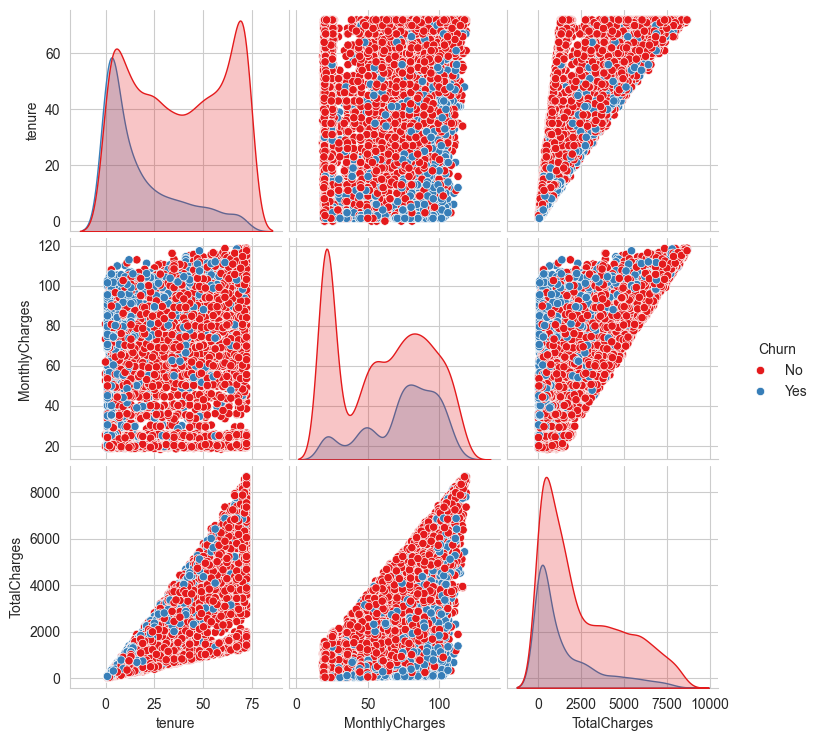

In [32]:
sns.pairplot(data, hue="Churn")
plt.show()

Tampak bahwa variabel Tenure dan Montlhy Charges tidak memiliki hubungan. Sedangkan variabel Total Charges meningkat seiring dengan bertambahnya Tenure atau Monthly Charges.

### 2.4.2 Cross-correlation analysis

In [33]:
vars_object = data.select_dtypes(include='object').columns # Mengambil variabel kategorik
data_onehot = pd.get_dummies(data, columns = vars_object) # Encoding variabel kategorik
# Hapus beberapa kolom yang hanya memiliki 2 grup
del data_onehot["gender_Male"]
del data_onehot["SeniorCitizen_No"]
del data_onehot["Partner_No"]
del data_onehot["Dependents_No"]
del data_onehot["PhoneService_No"]
del data_onehot["PaperlessBilling_No"]
del data_onehot["Churn_No"]

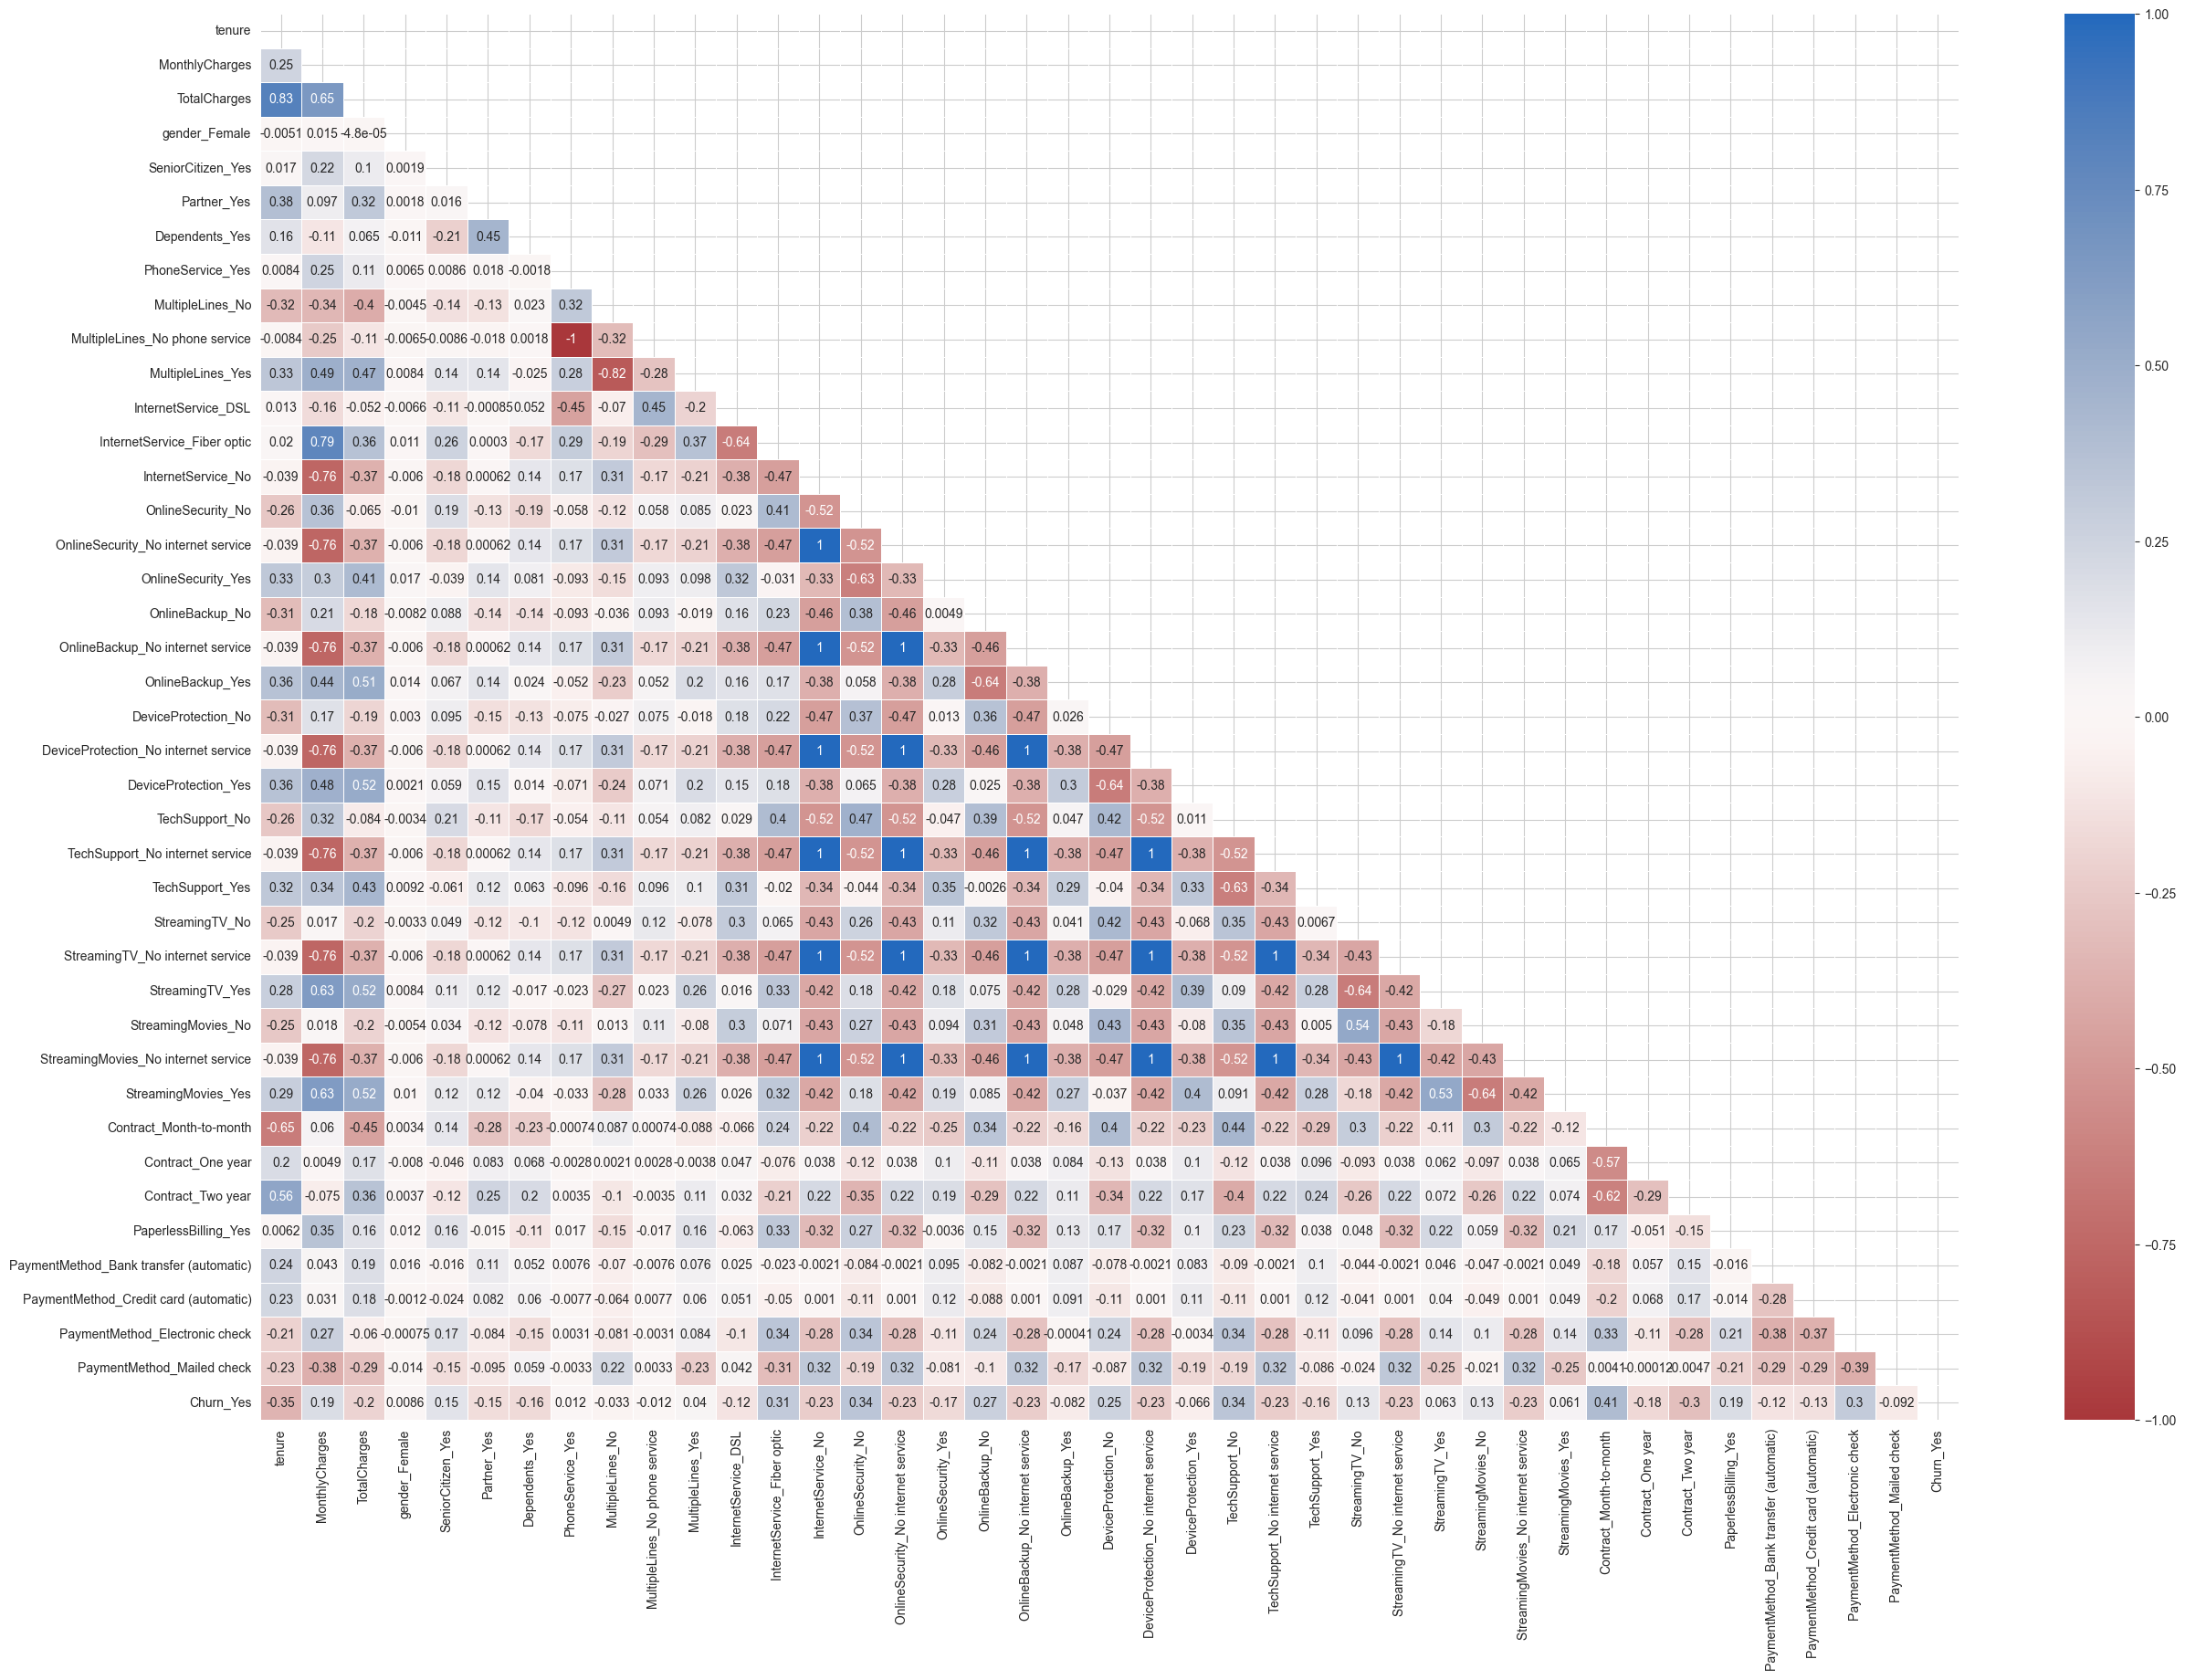

In [34]:
plt.figure(figsize=(30,20))
corrMatrix = data_onehot.corr()
mask = np.triu(np.ones_like(data_onehot.corr(), dtype=bool))
sns.heatmap(corrMatrix, annot=True, cmap="vlag_r", linewidths=0.5, linecolor='white', mask=mask)
plt.show()

Terdapat korelasi yang tinggi antara beberapa variabel, terutama pada variabel service. Hal ini perlu diperhatikan dalam tahap pre-processing untuk pemodelan statistik, guna mengurangi kompleksitas model dan meningkatkan explainability.

Korelasi positif yang tinggi ada di antara variabel tenure dengan total charges.

Terkait kecenderungan untuk berhenti berlangganan (Churn = yes), variabel penting yang memiliki korelasi positif adalah Contract month-to-month, sedangankan variabel penting yang memiliki korelasi negatif terhadapa Churn adalah Tenure.